# Segmentation Exercise

In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. 
Below is the code for setting up a segmentation network and training it. The network isn't very good, **so the exercise is to improve the quality of the segmentation by improving the network and/or the training scheme including data loading efficiency and data augmentation**. 

The data being used here is derived from the [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac MR images, filtered to contain only left ventricular myocardium segmentations and reduced in the XY dimensions.

First we install and import MONAI plus other dependencies:

In [4]:
%matplotlib inline

from urllib.request import urlopen
from io import BytesIO

import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.utils import first
from monai.transforms import Transform, Compose, AddChannel, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import progress_bar

device = torch.device("cuda:0")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"

batch_size = 50
num_workers = 2
num_epochs = 200
lr = 5e-3

We now load the data from the remote source and visualize a sample:

(420, 64, 64) (420, 64, 64)


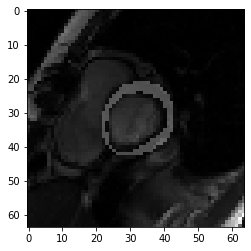

In [5]:
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())
data = np.load(npz)  # load all the data from the archive

images = data["images"]  # images in BHW array order
segs = data["segs"]  # segmentations in BHW array order
case_indices = data["caseIndices"]  # the indices in `images` for each case

images = images.astype(np.float32) / images.max()  # normalize images

print(images.shape, segs.shape)
plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  # show image 13 with segmentation

We will split our data into a training and validation set by keeping the last 6 cases as the latter:

In [6]:
test_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:test_index], segs[:test_index]
test_images, test_segs = images[test_index:], segs[test_index:]

We can now create a MONAI data loading object to compose batches during training, and another for validation:

In [7]:
image_trans = Compose(
    [
        ScaleIntensity(),  # rescale image data to range [0,1]
        AddChannel(),  # add 1-size channel dimension
        ToTensor(),  # convert to tensor
    ]
)

seg_trans = Compose([AddChannel(), ToTensor()])

ds = ArrayDataset(train_images, image_trans, train_segs, seg_trans)
loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_ds = ArrayDataset(test_images, image_trans, test_segs, seg_trans)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

im, seg = first(loader)
print(im.shape, im.min(), im.max(), seg.shape)

torch.Size([50, 1, 64, 64]) tensor(0.) tensor(1.) torch.Size([50, 1, 64, 64])


We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

In [8]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # layer 1: convolution, normalization, downsampling
            nn.Conv2d(1, 2, 3, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
            # layer 2
            nn.Conv2d(2, 4, 3, 1, 1),
            # layer 3
            nn.ConvTranspose2d(4, 2, 3, 2, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            # layer 4: output
            nn.Conv2d(2, 1, 3, 1, 1),
        )

    def forward(self, x):
        return self.model(x)

Our training scheme is very simple. For each epoch we train on each batch of images from the training set, thus training with each image once, and then evaluate with the validation set.

In [9]:
net = SegNet()
net = net.to(device)

opt = torch.optim.Adam(net.parameters(), lr)
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(
    include_background=True, to_onehot_y=False, sigmoid=True, reduction="mean"
)

step_losses = []
epoch_metrics = []
total_step = 0

for epoch in range(num_epochs):
    net.train()

    # train network with training images
    for bimages, bsegs in loader:
        bimages = bimages.to(device)
        bsegs = bsegs.to(device)

        opt.zero_grad()

        prediction = net(bimages)
        loss_val = loss(prediction, bsegs)
        loss_val.backward()
        opt.step()

        step_losses.append((total_step, loss_val.item()))
        total_step += 1

    net.eval()
    metric_vals = []

    # test our network using the validation dataset
    with torch.no_grad():
        for bimages, bsegs in val_loader:
            bimages = bimages.to(device)
            bsegs = bsegs.to(device)

            prediction = net(bimages)
            pred_metric = metric(prediction, bsegs)
            metric_vals.append(pred_metric.item())

    epoch_metrics.append((total_step, np.average(metric_vals)))

    progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:.3}")

200/200 Validation Metric: 0.227 [==============================]]


We now graph the results from our training and find the results are not very good:

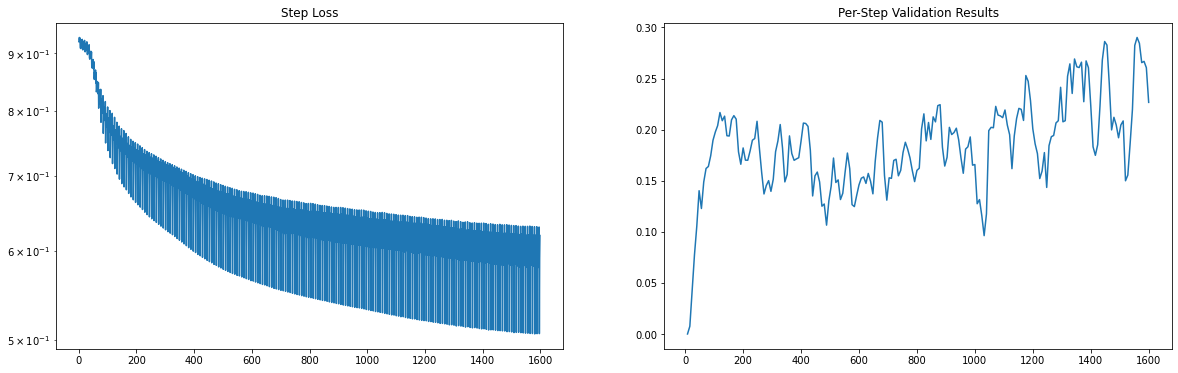

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].semilogy(*zip(*step_losses))
ax[0].set_title("Step Loss")

ax[1].plot(*zip(*epoch_metrics))
ax[1].set_title("Per-Step Validation Results")
plt.show()

As you can see we're not getting good results from our network. The training loss values are jumping around and not decreasing much anymore. The validation score has topped out at 0.25, which is really poor. 

It's now up to you to improve the results of our segmentation task. The things to consider changing include the network itself, how data is loaded, how batches might be composed, and what transforms we want to use from MONAI. 